In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyross

## Introduction

In this notebook, we consider an SIR model with a lockdown protocol that is put in place once the infective population exceeds a threshold, and is removed once the infective population falls below a second threshold.

## Define system parameters

In [3]:
# Define basic system parameters

M = 1                  # the SIR model has no age structure
Ni = 50000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

beta  = 0.2          # infection rate
gamma = 0.1         # recovery rate 
alpha = 0.0            # fraction of asymptomatic infectives 
fsa   = 1              # the self-isolation parameter 

Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([10])    # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

parameters = {'alpha':alpha, 'beta':beta,'fsa':fsa,
             'gIa':gamma,'gIs':gamma}

model = pyross.control.SIR(parameters, M, Ni)

## Define events at which contact matrix is modified

For every change in the contact matrix that could occur, we have to define an *event*. An event is a function of time and the current state, and the event happens once the function becomes zero (from a given side).

The program expects 
* a list of events, and 
* a list of contact matrices.

If event $i$ takes place, then the $i$-th contact matrix from the list is used in the simulation.

The simulation always starts with the first contact matrix from the list, and the corresponding event can only occur once another event has occured (below we will use a dummy event that can never occur).

We now define three events:

In [4]:
events = []
contactMatrices = []

# Note that for technical reasons, the event functions take a
# vector argument "rp" instead of a tuple (S,Ia,Is).
# When defining the event functions, the following correspondence has to be used:
# S  == rp[ :M]
# Ia == rp[M:2*M]
# Is == rp[2*M: ]

# This is a dummy event which will never occur; it is used to set the initial contact matrix
def cur_event(t,rp):
    return t + 1
cur_event.direction = +1
events.append(cur_event)
contactMatrices.append( np.identity(M) )

# Lockdown (= multiply beta by a factor 1/2) once number of infectives I_s becomes larger than 5000
def cur_event2(t,rp):
    return rp[2] - 5000
cur_event2.direction = +1 # this means we need to pass the threshold from below for the event to happen
events.append(cur_event2)
contactMatrices.append( 0.5*np.identity(M) )

# End of lockdown once number of infectives I_s becomes smaller than 1000 (and has been larger before)
def cur_event3(t,rp):
    return rp[2] - 1000
cur_event3.direction = -1 # this means we need to pass the threshold from above for the event to happen
events.append(cur_event3)
contactMatrices.append( 1*np.identity(M) )

## Simulate system and plot result

In [5]:
# Run simulation
Tf = 300
Nt = (Tf +1)*10

result = model.simulate(S0, Ia0, Is0 ,events=events,contactMatrices=contactMatrices,Tf=Tf, Nf=Nt)

event_labels = ['','lockdown starts','lockdown ends']
for i,e in enumerate(result['events_occured']):
    print("After {0:3.1f} days, the {1}.".format(e[0],event_labels[e[1]]))

After 67.8 days, the lockdown starts.
After 114.9 days, the lockdown ends.


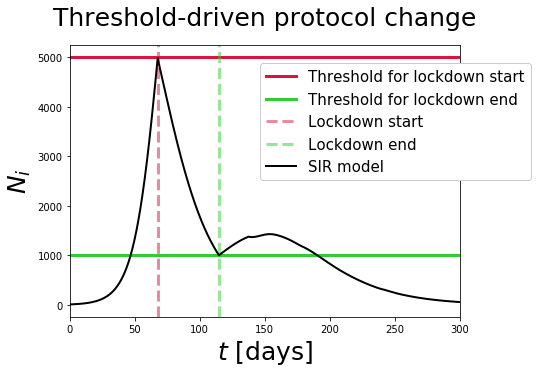

In [10]:
# Plot result
t_arr = result['t']
trajs = result['X'].T

fontsize=25
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.set_title('Threshold-driven protocol change',
            y=1.05,fontsize=25)
ax.axhline(5000,color='crimson',
           lw=3,
           label='Threshold for lockdown start')
ax.axhline(1000,color='limegreen',
           lw=3,
          label='Threshold for lockdown end')
for i,e in enumerate(result['events_occured']):
    if e[1] == 1:
        label='Lockdown start'
        color='crimson'
    else:
        label='Lockdown end'
        color='limegreen'
    ax.axvline(e[0],label=label,
               color=color,
               lw=3,
               ls='--',alpha=0.5)

for i,traj in enumerate(trajs):
    if i != 2:
        continue
    ax.plot(t_arr,traj,
            label='SIR model', 
            color='black',
            lw=2,
           )
ax.set_xlim(np.min(t_arr),np.max(t_arr))
ax.set_ylabel(r'$N_i$',fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.2,0.96),
          framealpha=1,
         fontsize=15)
plt.show()
#fig.savefig('threshold_driven_protocol_change.png',bbox_inches='tight',
#           dpi=100)
plt.close()

## Speed test: Compare simulation without state-dependent protocol to simulations with state-dependent lockdown

In [7]:
from timeit import default_timer as timer

In [8]:
# run "standard" deterministic simulations

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

model = pyross.deterministic.SIR(parameters, M, Ni)

N_runs = 1000 # runs to average over
start = timer()
for i in range(N_runs):
    result = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt)
end = timer()

total_time_1 = end - start
print('Standard simulations: Time per simulation = {0:3.4f} ms'.format(total_time_1/N_runs*1000))

Standard simulations: Time per simulation = 10.3001 ms


In [11]:
# run state-dependent lockdown simulations

model = pyross.control.SIR(parameters, M, Ni)

N_runs = 1000 # runs to average over
start = timer()
for i in range(N_runs):
    result = model.simulate(S0, Ia0, Is0 ,events=events,contactMatrices=contactMatrices,Tf=Tf, Nf=Nt)
end = timer()

total_time_2 = end - start
print('Standard simulations: Time per simulation = {0:3.4f} ms\n'.format(total_time_2/N_runs*1000))

print('-> The lockdown-protocol slows down the simulations by a factor of about {0:3.1f}'.format(total_time_2/total_time_1))

Standard simulations: Time per simulation = 15.3926 ms

-> The lockdown-protocol slows down the simulations by a factor of about 1.5
